In [1]:
import sys, os
from pathlib import Path
import pandas as pd
import numpy as np
from pandas.util.testing import assert_frame_equal

from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
import joblib

from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sys.path.append("..")
from btc_predictor.utils import preproc

In [2]:
df = pd.read_csv("../btc_predictor/datasets/btcusd.csv")

In [3]:
BTCUSD  = preproc(df.copy())

BTCUSD['log_ret'] = np.log(BTCUSD.Close) - np.log(BTCUSD.Close.shift(1))

BTCUSD['baseline_Close'] = BTCUSD.Close.shift(1)
BTCUSD['baseline_log_ret'] = np.log(BTCUSD.baseline_Close) - np.log(BTCUSD.baseline_Close.shift(1))
BTCUSD.dropna(inplace=True)

# 1. Establishing Baseline

In [4]:
np.sqrt(mean_absolute_error(BTCUSD.Close, BTCUSD.baseline_Close))

9.95356055887107

In [5]:
BTCUSD.Close.describe()

count     2031.000000
mean      2928.330074
std       3627.266960
min        178.100000
25%        420.485000
50%        739.250000
75%       5048.250000
max      19497.400000
Name: Close, dtype: float64

Due to the wild fluctuations of BTCUSD prices, from \\$700s at the beginning of our data stream to \\$10,000s towards the end, root mean squared error become an useless metric as the former erorr will miniscule compare to the later errors. Instead, we will look at the RMSE of the normalized and stationary log return.

In [6]:
np.sqrt(mean_squared_error(BTCUSD.log_ret, BTCUSD.baseline_log_ret))

0.05635804810175371

The loss is around 5%, which means the prior day return is an extremely great predictor of current day return. It would be hard to beat that. But the story will change if we look at the directions of the return. The direction of the return is more important than the magnitude of the return, i.e., a trade will be money losing when the direction is wrong.

In [7]:
print("Baseline RMSE is {:.4f}, directional accuracy is {:.4f}".format(
                                np.sqrt(mean_squared_error(BTCUSD.log_ret, BTCUSD.baseline_log_ret)),
                                accuracy_score(np.sign(BTCUSD.log_ret), np.sign(BTCUSD.baseline_log_ret))))

Baseline RMSE is 0.0564, directional accuracy is 0.4884


In [8]:
accuracy_score(np.sign(BTCUSD.log_ret), np.sign(BTCUSD.baseline_log_ret))

0.48842934515017233

In [9]:
np.sign(BTCUSD.log_ret).unique(), np.sign(BTCUSD.baseline_log_ret).unique()

(array([-1.,  1.,  0.]), array([ 1., -1.,  0.]))

As expected, the direction of prior day log returns is a poor predictor of the direction of current day log returns. While we can obsess with minimizing the RMSE to get a 'better' prediction, we won't be able to capitalize on that prediction until we get the direction right. Thus, it would be economically more important to obtain a better direction prediction than a better magnitude direction.

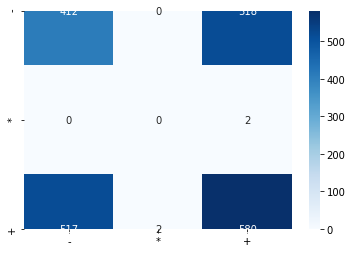

In [10]:
df_cm = pd.DataFrame(confusion_matrix(np.sign(BTCUSD.log_ret), np.sign(BTCUSD.baseline_log_ret)),  
                     index = [i for i in "-*+"],
                     columns = [i for i in "-*+"])
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g');

## 1.2 Autoregressive (AR) Model

In [11]:
train = BTCUSD.iloc[0:1700, :]['log_ret']
test = BTCUSD.iloc[1700:, :]['log_ret']

In [12]:
ar = AR(train, freq='D').fit()

y_pred = ar.predict(test.index[0], test.index[-1], dynamic=True)
assert len(y_pred) == test.shape[0]

In [13]:
print("Prediction RMSE is {:.4f}, directional accuracy is {:.4f}".format(
                                                        np.sqrt(mean_squared_error(y_pred, test)),
                                                        accuracy_score(np.sign(test), np.sign(y_pred))))

Prediction RMSE is 0.0379, directional accuracy is 0.5559


## 1.3 Univariate Autoregressive integrated Moving Average (ARIMA) Model

In [14]:
train = BTCUSD.iloc[0:1700, :]['log_ret']
test = BTCUSD.iloc[1700:, :]['log_ret']

In [15]:
def metrics(y, y_pred):
    print("Prediction RMSE is {:.4f}, directional accuracy is {:.4f}".format(
                                        np.sqrt(mean_squared_error(y, y_pred)),
                                        accuracy_score(np.sign(y), np.sign(y_pred))))
    pass

In [16]:
%time arima = ARIMA(train, order = (3,1,0), freq='D').fit(disp = 0)
y_pred_arima = arima.predict(test.index[0], test.index[-1], dynamic = True)

Wall time: 215 ms


In [17]:
y_pred_arima

2018-08-23    0.012709
2018-08-24    0.001075
2018-08-25    0.003010
2018-08-26   -0.005729
2018-08-27    0.002425
                ...   
2019-07-15    0.000004
2019-07-16    0.000004
2019-07-17    0.000004
2019-07-18    0.000004
2019-07-19    0.000004
Freq: D, Length: 331, dtype: float64

In [18]:
test[:8]

Date
2018-08-23    0.024502
2018-08-24    0.027928
2018-08-25    0.006412
2018-08-26   -0.008304
2018-08-27    0.026102
2018-08-28    0.030278
2018-08-29   -0.006946
2018-08-30   -0.009829
Name: log_ret, dtype: float64

In [19]:
metrics(test, y_pred_arima)

Prediction RMSE is 0.0378, directional accuracy is 0.5650


That's a big improvement to our baseline of 0.056 RMSE and 0.4884 direction accuracy. Let's visualize our predictions.

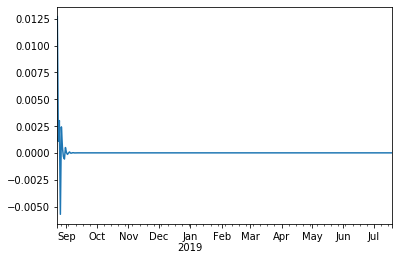

In [20]:
y_pred_arima.plot();

To get back prices from log returns, we multiply current period price by predicted next period return `np.exp(log_ret)`.

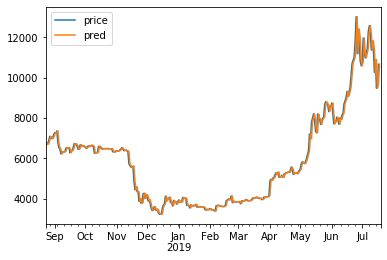

In [21]:
y_true_s = pd.Series(np.exp(test.shift(-1)) *  BTCUSD.iloc[1700:, :]['Close'])# test_df.Close)
y_arima_pred_s = pd.Series(np.exp(y_pred_arima.shift(-1)) *  BTCUSD.iloc[1700:, :]['Close'])#test_df.Close)

foo = pd.concat([y_true_s, y_arima_pred_s], axis=1)
foo.columns = ['price', 'pred']
foo.plot();

It seems like the predictive power quickly diminishes to just using last price after a few forward periods. Let's look at how the predictive power of the first 7 periods.

In [22]:
y_pred_arima = arima.predict(test.index[0], test.index[7], dynamic = True)
metrics(test[:8], y_pred_arima)

Prediction RMSE is 0.0175, directional accuracy is 1.0000


That's super interesting. Perhaps the RNGesus favored us there. Let's just use a rolling 60 day window for training to predict the next 9 period price.

## 1.4 Rolling Window ARIMA

In [68]:
clone = BTCUSD.copy()
start = 1700
end = 2031
window = 60 #60
y_rolling_arima = pd.Series([])
periods = range(start-window, end, 1) #9

In [70]:
for p in periods:
    ptrain = clone.iloc[(p - window):p, :]['log_ret']
    ptest = clone.iloc[p:p+1, :]['log_ret']
    model = ARIMA(ptrain, order = (3,1,0), freq='D').fit(disp = 0)
    predict = model.predict(ptest.index[0], ptest.index[-1], dynamic = True) #-1
    y_rolling_arima = y_rolling_arima.append(predict)

c:\users\han-chung lee\.virtualenvs\btc_dash-bupzssx2\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\han-chung lee\.virtualenvs\btc_dash-bupzssx2\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [66]:
y_rolling_arima.shape

(44,)

In [67]:
BTCUSD.iloc[1670:,:]['log_ret'].shape

(361,)

In [61]:
metrics(BTCUSD.iloc[1670:,:]['log_ret'], y_rolling_arima)

Prediction RMSE is 0.0512, directional accuracy is 0.5125


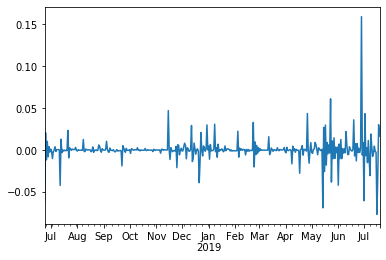

In [28]:
y_rolling_arima.plot();

With the 60 days rolling ARIMA calculations, the prediction RMSE is better and does not simply attenuates to using last close as the prediction. The directional accuracy is slightly better than a random guess and better than our baseline of using last period direction. This would also be similar to live situation where models are tuned on a daily basis.

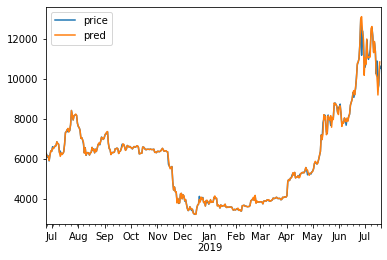

In [30]:
y_true = pd.Series(BTCUSD.iloc[1640:, :]['Close'])
y_rolling_arima_pred = pd.Series(np.exp(y_rolling_arima.shift(-1)) *  BTCUSD.iloc[1640:, :]['Close'])

foo = pd.concat([y_true, y_rolling_arima_pred], axis=1)
foo.columns = ['price', 'pred']
foo.plot();